In [ ]:
# prepare image, mask from 206 segmentations data
import os
import random
import cv2
import time
import pandas as pd
import nibabel as nib
import pydicom
import numpy as np

from glob import glob
from tqdm import tqdm
from pathlib import Path
from monai.transforms import Resize

from sklearn.model_selection import GroupKFold

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class CFG:
    image_sizes = [128, 128, 128]
    backbone = 'resnet18'
    drop_rate = 0.
    drop_path_rate = 0.
    n_blocks = 4
    out_dim = 5
    loss_weights = [1, 1]
    init_lr = 3e-3
    batch_size = 4
    num_workers = 4
    n_epochs = 1000
    device = torch.device('cuda')
    p_mixup = 0.1

In [3]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (CFG.image_sizes[0], CFG.image_sizes[1]), interpolation = cv2.INTER_LINEAR)
    return data

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
#         pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2    
    
    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array


In [4]:
Path(f"data/stage2").mkdir(parents=True, exist_ok=True)
Path(f"data/stage2/image").mkdir(parents=True, exist_ok=True)
Path(f"data/stage2/mask").mkdir(parents=True, exist_ok=True)
seg_path = 'data/segmentations/'
src_data = 'data/train_images'
df = pd.read_parquet("data/train_dicom_tags.parquet")
df['StudyInstanceUID'] = df['SeriesInstanceUID'].apply(lambda x: x.split('.')[-1])

In [1]:
dataframe_list = []
for idx, filename in tqdm(enumerate(os.listdir(seg_path))):
    if idx > 10:
        break
    ex_path = os.path.join(seg_path, filename)
    print(ex_path)
    mask_org = nib.load(ex_path)
    mask_org = mask_org.get_fdata()
    mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1] # (d, w, h)
  
    shape = mask_org.shape
    mask = np.zeros((5, shape[0], shape[1], shape[2]))
    for cid in range(5):
        mask[cid] = (mask_org == (cid + 1))
    mask = mask.astype(np.uint8) * 255
    mask = Resize(CFG.image_sizes)(mask).numpy()
    
    study_id = filename.split('.')[0]
    row = df[df['StudyInstanceUID'] == study_id]
    patient_id = row['PatientID'].unique().tolist()
    assert len(patient_id) == 1, "the study should be of a patient"
    patient_id = str(patient_id[0])

    train_image_path = glob(f"{src_data}/{patient_id}/{study_id}/*")
    train_image_path = sorted(train_image_path, key=lambda x:int(x.split("/")[-1].replace(".dcm", "")))
    n_scans = len(train_image_path)
   
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., CFG.image_sizes[2])).round().astype(int)

    t_paths = [train_image_path[i] for i in indices]
    images = []
    # old code
    for filename in t_paths:
        images.append(load_dicom(filename))
    images = np.stack(images, -1)
    images = images - np.min(images)
    images = images / (np.max(images) + 1e-4)
    images = (images * 255).astype(np.uint8)
    
    
    image_save_path = f"data/stage2/image/{study_id}.npy"
    mask_save_path = f"data/stage2/mask/{study_id}.npy"
    np.save(image_save_path, images)
    np.save(mask_save_path, mask)
    dataframe_list.append([study_id, image_save_path, mask_save_path])

NameError: name 'tqdm' is not defined

In [19]:
dataframe_list

[['6575', 'data/stage2/image/6575.npy', 'data/stage2/mask/6575.npy'],
 ['62556', 'data/stage2/image/62556.npy', 'data/stage2/mask/62556.npy'],
 ['60755', 'data/stage2/image/60755.npy', 'data/stage2/mask/60755.npy'],
 ['60302', 'data/stage2/image/60302.npy', 'data/stage2/mask/60302.npy'],
 ['31852', 'data/stage2/image/31852.npy', 'data/stage2/mask/31852.npy'],
 ['6172', 'data/stage2/image/6172.npy', 'data/stage2/mask/6172.npy'],
 ['8413', 'data/stage2/image/8413.npy', 'data/stage2/mask/8413.npy'],
 ['54830', 'data/stage2/image/54830.npy', 'data/stage2/mask/54830.npy'],
 ['30522', 'data/stage2/image/30522.npy', 'data/stage2/mask/30522.npy'],
 ['34232', 'data/stage2/image/34232.npy', 'data/stage2/mask/34232.npy'],
 ['39205', 'data/stage2/image/39205.npy', 'data/stage2/mask/39205.npy']]

In [20]:
seg_3d_df = pd.DataFrame(dataframe_list, columns=["StudyInstanceUID", "image_path", "mask_path"])
seg_3d_df['fold'] = -1
gkf = GroupKFold(n_splits=5)
for idx, (train_idx, test_idx) in enumerate(gkf.split(X=seg_3d_df, groups=seg_3d_df['StudyInstanceUID'].values)):
    seg_3d_df.loc[test_idx, 'fold'] = idx
seg_3d_df.to_csv('data/stage1/seg_3d.csv', index=False)

In [5]:
import torch
import monai.transforms as transforms
import matplotlib.pyplot as plt
from pylab import rcParams
from torch.utils.data import DataLoader, Dataset
%matplotlib inline
rcParams['figure.figsize'] = 20, 8

transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(CFG.image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])


class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):
        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        infos = self.df.iloc[index]
        image = np.load(infos['image_path'])
        mask = np.load(infos['mask_path'])
        
        if image.ndim < 4:
            image = np.expand_dims(image, 0).repeat(3, 0)
        
        res = self.transform({'image': image, 'mask': mask})
        # image = res['image'] / 255.
        # mask = res['mask']
        image = image / 255.
        mask = (mask > 127).astype(np.float32)
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
        return image, mask


dataset_show = SEGDataset(seg_3d_df, 'train', transform=transforms_train)
                         

for i in range(2):
    f, axarr = plt.subplots(1,4)
    for p in range(4):
        idx = i*4+p
        img, mask = dataset_show[idx]
        print('debug')
        print(img.shape)
        print(mask.shape)
        img = img[:, :, 60]
        mask = mask[:, :, 60]
        # mask[0] = mask[0] + mask[1]
        # mask[1] = mask[2] + mask[3]
        # mask[2] = mask[4]
        mask = mask[:3]
        img = img * 0.7 + mask * 0.3
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())



NameError: name 'seg_3d_df' is not defined

In [80]:
import torch.nn as nn
import timm
import segmentation_models_pytorch as smp
from timm.layers import Conv2dSame
from conv3d_same import Conv3dSame


class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        n_blocks = CFG.n_blocks
        if segtype == 'unet':
            self.decoder = smp.decoders.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], CFG.out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:CFG.n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features


def convert_3d(module):
    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    # elif isinstance(module, Conv2dSame):
    #     module_output = Conv3dSame(
    #         in_channels=module.in_channels,
    #         out_channels=module.out_channels,
    #         kernel_size=module.kernel_size[0],
    #         stride=module.stride[0],
    #         padding=module.padding[0],
    #         dilation=module.dilation[0],
    #         groups=module.groups,
    #         bias=module.bias is not None,
    #     )
    #     module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(CFG.backbone)
m = convert_3d(m)
m(torch.rand(1, 3, 128, 128, 128)).shape

torch.Size([1, 5, 128, 128, 128])

In [84]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=CFG.loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

In [121]:
# training
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < CFG.p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)

/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unab

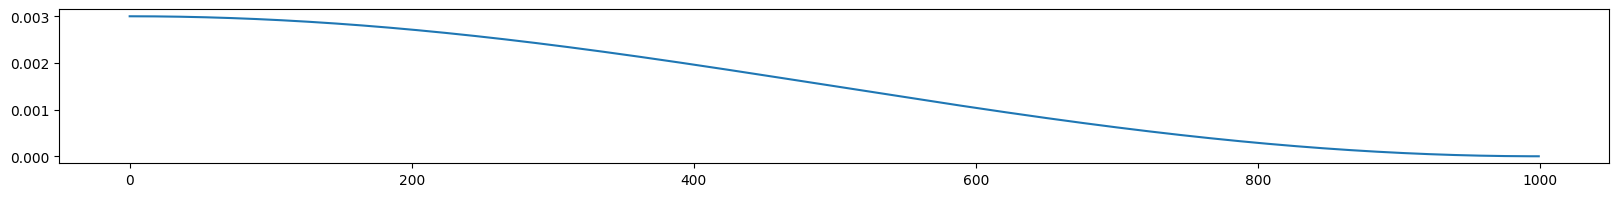

In [90]:
# parameter
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=CFG.init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

In [123]:
# training
log_dir = './logs'
model_dir = './weights'
DEBUG = False
Path(log_dir).mkdir(parents=True, exist_ok=True)
Path(model_dir).mkdir(parents=True, exist_ok=True)
def run(fold):
    log_file = os.path.join(log_dir, f'{CFG.backbone}_fold{fold}.txt')
    model_file = os.path.join(model_dir, f'{CFG.backbone}_fold{fold}_best.pth')
    df_seg = pd.read_csv('data/stage1/seg_3d.csv')
    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
    model = TimmSegModel(CFG.backbone, pretrained=True)
    model = convert_3d(model)
    model = model.to(CFG.device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs + 1):
        scheduler_cosine.step(epoch - 1)
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)
        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
run(0)

164 42
Thu Sep 21 15:44:53 2023 Epoch: 1


smth:0.3571: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.39s/it]


best th: 0.2 best dc: 0.18754940003062384
Thu Sep 21 15:46:54 2023 Fold 0, Epoch 1, lr: 0.0030000, train loss: 0.36867, valid loss: 0.35706, metric: 0.187549.
metric_best (0.000000 --> 0.187549). Saving model ...
Thu Sep 21 15:46:56 2023 Epoch: 2


smth:0.2807: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.43s/it]


best th: 0.2 best dc: 0.2128234150168301
Thu Sep 21 15:49:19 2023 Fold 0, Epoch 2, lr: 0.0030000, train loss: 0.23895, valid loss: 0.28074, metric: 0.212823.
metric_best (0.187549 --> 0.212823). Saving model ...
Thu Sep 21 15:49:23 2023 Epoch: 3


smth:0.2519: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.53s/it]


best th: 0.2 best dc: 0.24233986012650024
Thu Sep 21 15:52:05 2023 Fold 0, Epoch 3, lr: 0.0030000, train loss: 0.21403, valid loss: 0.25194, metric: 0.242340.
metric_best (0.212823 --> 0.242340). Saving model ...
Thu Sep 21 15:52:09 2023 Epoch: 4


smth:0.2162: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.47s/it]


best th: 0.2 best dc: 0.27353575828246135
Thu Sep 21 15:55:04 2023 Fold 0, Epoch 4, lr: 0.0029999, train loss: 0.20760, valid loss: 0.21619, metric: 0.273536.
metric_best (0.242340 --> 0.273536). Saving model ...
Thu Sep 21 15:55:09 2023 Epoch: 5


smth:0.2263: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.63s/it]


best th: 0.2 best dc: 0.26965148102670367
Thu Sep 21 15:58:04 2023 Fold 0, Epoch 5, lr: 0.0029999, train loss: 0.19799, valid loss: 0.22626, metric: 0.269651.
Thu Sep 21 15:58:07 2023 Epoch: 6


smth:0.2075: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:46<00:00,  4.27s/it]


best th: 0.2 best dc: 0.2788963579872684
Thu Sep 21 16:01:16 2023 Fold 0, Epoch 6, lr: 0.0029998, train loss: 0.18647, valid loss: 0.20745, metric: 0.278896.
metric_best (0.273536 --> 0.278896). Saving model ...
Thu Sep 21 16:01:20 2023 Epoch: 7


smth:0.1919: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:46<00:00,  4.18s/it]


best th: 0.2 best dc: 0.2910225749213796
Thu Sep 21 16:04:40 2023 Fold 0, Epoch 7, lr: 0.0029997, train loss: 0.19003, valid loss: 0.19194, metric: 0.291023.
metric_best (0.278896 --> 0.291023). Saving model ...
Thu Sep 21 16:04:44 2023 Epoch: 8


smth:0.1747: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:44<00:00,  4.05s/it]


best th: 0.2 best dc: 0.30567961974445956
Thu Sep 21 16:07:49 2023 Fold 0, Epoch 8, lr: 0.0029996, train loss: 0.17955, valid loss: 0.17466, metric: 0.305680.
metric_best (0.291023 --> 0.305680). Saving model ...
Thu Sep 21 16:07:53 2023 Epoch: 9


smth:0.1931: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:47<00:00,  4.33s/it]


best th: 0.2 best dc: 0.29211701963786624
Thu Sep 21 16:11:16 2023 Fold 0, Epoch 9, lr: 0.0029995, train loss: 0.17932, valid loss: 0.19307, metric: 0.292117.
Thu Sep 21 16:11:19 2023 Epoch: 10


smth:0.1748: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:46<00:00,  4.27s/it]


best th: 0.2 best dc: 0.3097809975508834
Thu Sep 21 16:14:41 2023 Fold 0, Epoch 10, lr: 0.0029994, train loss: 0.16302, valid loss: 0.17475, metric: 0.309781.
metric_best (0.305680 --> 0.309781). Saving model ...
Thu Sep 21 16:14:45 2023 Epoch: 11


smth:0.1728: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:47<00:00,  4.34s/it]


best th: 0.2 best dc: 0.3038120823691837
Thu Sep 21 16:18:22 2023 Fold 0, Epoch 11, lr: 0.0029993, train loss: 0.15973, valid loss: 0.17284, metric: 0.303812.
Thu Sep 21 16:18:24 2023 Epoch: 12


smth:0.1770: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:47<00:00,  4.34s/it]


best th: 0.2 best dc: 0.3169500557898387
Thu Sep 21 16:21:57 2023 Fold 0, Epoch 12, lr: 0.0029991, train loss: 0.15586, valid loss: 0.17704, metric: 0.316950.
metric_best (0.309781 --> 0.316950). Saving model ...
Thu Sep 21 16:22:01 2023 Epoch: 13


smth:0.1624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.82s/it]


best th: 0.2 best dc: 0.42331226641854997
Thu Sep 21 16:25:21 2023 Fold 0, Epoch 13, lr: 0.0029989, train loss: 0.14201, valid loss: 0.16238, metric: 0.423312.
metric_best (0.316950 --> 0.423312). Saving model ...
Thu Sep 21 16:25:24 2023 Epoch: 14


smth:0.1808: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:41<00:00,  3.82s/it]


best th: 0.2 best dc: 0.44537800088566676
Thu Sep 21 16:28:47 2023 Fold 0, Epoch 14, lr: 0.0029987, train loss: 0.13495, valid loss: 0.18077, metric: 0.445378.
metric_best (0.423312 --> 0.445378). Saving model ...
Thu Sep 21 16:28:52 2023 Epoch: 15


smth:0.1939: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.93s/it]


best th: 0.2 best dc: 0.40415686619561514
Thu Sep 21 16:32:28 2023 Fold 0, Epoch 15, lr: 0.0029985, train loss: 0.14354, valid loss: 0.19391, metric: 0.404157.
Thu Sep 21 16:32:31 2023 Epoch: 16


smth:0.1564: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  4.00s/it]


best th: 0.2 best dc: 0.5401029662110494
Thu Sep 21 16:36:03 2023 Fold 0, Epoch 16, lr: 0.0029983, train loss: 0.13747, valid loss: 0.15642, metric: 0.540103.
metric_best (0.445378 --> 0.540103). Saving model ...
Thu Sep 21 16:36:07 2023 Epoch: 17


smth:0.1631: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:47<00:00,  4.29s/it]


best th: 0.2 best dc: 0.5577854797856365
Thu Sep 21 16:39:36 2023 Fold 0, Epoch 17, lr: 0.0029981, train loss: 0.12598, valid loss: 0.16314, metric: 0.557785.
metric_best (0.540103 --> 0.557785). Saving model ...
Thu Sep 21 16:39:39 2023 Epoch: 18


smth:0.1907: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  4.00s/it]


best th: 0.2 best dc: 0.5664354698292204
Thu Sep 21 16:43:08 2023 Fold 0, Epoch 18, lr: 0.0029979, train loss: 0.11399, valid loss: 0.19071, metric: 0.566435.
metric_best (0.557785 --> 0.566435). Saving model ...
Thu Sep 21 16:43:13 2023 Epoch: 19


smth:0.1566: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.98s/it]


best th: 0.2 best dc: 0.616050646553172
Thu Sep 21 16:46:39 2023 Fold 0, Epoch 19, lr: 0.0029976, train loss: 0.12150, valid loss: 0.15659, metric: 0.616051.
metric_best (0.566435 --> 0.616051). Saving model ...
Thu Sep 21 16:46:42 2023 Epoch: 20


smth:0.1526: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:44<00:00,  4.07s/it]


best th: 0.2 best dc: 0.6721857806302997
Thu Sep 21 16:50:08 2023 Fold 0, Epoch 20, lr: 0.0029973, train loss: 0.11412, valid loss: 0.15257, metric: 0.672186.
metric_best (0.616051 --> 0.672186). Saving model ...
Thu Sep 21 16:50:11 2023 Epoch: 21


smth:0.1178: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.86s/it]


best th: 0.2 best dc: 0.7520190096637335
Thu Sep 21 16:53:29 2023 Fold 0, Epoch 21, lr: 0.0029970, train loss: 0.10397, valid loss: 0.11781, metric: 0.752019.
metric_best (0.672186 --> 0.752019). Saving model ...
Thu Sep 21 16:53:33 2023 Epoch: 22


smth:0.1353: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:41<00:00,  3.80s/it]


best th: 0.2 best dc: 0.6627275820329361
Thu Sep 21 16:56:46 2023 Fold 0, Epoch 22, lr: 0.0029967, train loss: 0.09519, valid loss: 0.13533, metric: 0.662728.
Thu Sep 21 16:56:48 2023 Epoch: 23


smth:0.1206: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.66s/it]


best th: 0.2 best dc: 0.7211742670951545
Thu Sep 21 16:59:42 2023 Fold 0, Epoch 23, lr: 0.0029964, train loss: 0.08845, valid loss: 0.12058, metric: 0.721174.
Thu Sep 21 16:59:44 2023 Epoch: 24


smth:0.1133: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.63s/it]


best th: 0.2 best dc: 0.7661105630663092
Thu Sep 21 17:02:46 2023 Fold 0, Epoch 24, lr: 0.0029961, train loss: 0.09218, valid loss: 0.11328, metric: 0.766111.
metric_best (0.752019 --> 0.766111). Saving model ...
Thu Sep 21 17:02:51 2023 Epoch: 25


smth:0.1043: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:41<00:00,  3.73s/it]


best th: 0.2 best dc: 0.7869340160687331
Thu Sep 21 17:05:50 2023 Fold 0, Epoch 25, lr: 0.0029957, train loss: 0.08302, valid loss: 0.10435, metric: 0.786934.
metric_best (0.766111 --> 0.786934). Saving model ...
Thu Sep 21 17:05:53 2023 Epoch: 26


smth:0.1031: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.90s/it]


best th: 0.2 best dc: 0.8018956783244708
Thu Sep 21 17:08:47 2023 Fold 0, Epoch 26, lr: 0.0029954, train loss: 0.07302, valid loss: 0.10310, metric: 0.801896.
metric_best (0.786934 --> 0.801896). Saving model ...
Thu Sep 21 17:08:50 2023 Epoch: 27


smth:0.1081: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:36<00:00,  3.32s/it]


best th: 0.2 best dc: 0.7891342526093867
Thu Sep 21 17:11:44 2023 Fold 0, Epoch 27, lr: 0.0029950, train loss: 0.08757, valid loss: 0.10812, metric: 0.789134.
Thu Sep 21 17:11:46 2023 Epoch: 28


smth:0.0974: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.46s/it]


best th: 0.2 best dc: 0.7794927953139763
Thu Sep 21 17:13:39 2023 Fold 0, Epoch 28, lr: 0.0029946, train loss: 0.07907, valid loss: 0.09745, metric: 0.779493.
Thu Sep 21 17:13:41 2023 Epoch: 29


smth:0.0972: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.67s/it]


best th: 0.2 best dc: 0.8025109969736081
Thu Sep 21 17:16:03 2023 Fold 0, Epoch 29, lr: 0.0029942, train loss: 0.07372, valid loss: 0.09723, metric: 0.802511.
metric_best (0.801896 --> 0.802511). Saving model ...
Thu Sep 21 17:16:07 2023 Epoch: 30


smth:0.0948: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.68s/it]


best th: 0.2 best dc: 0.8145563527474465
Thu Sep 21 17:18:49 2023 Fold 0, Epoch 30, lr: 0.0029938, train loss: 0.08022, valid loss: 0.09476, metric: 0.814556.
metric_best (0.802511 --> 0.814556). Saving model ...
Thu Sep 21 17:18:52 2023 Epoch: 31


smth:0.0934: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.56s/it]


best th: 0.2 best dc: 0.8197362810813547
Thu Sep 21 17:21:48 2023 Fold 0, Epoch 31, lr: 0.0029933, train loss: 0.06851, valid loss: 0.09342, metric: 0.819736.
metric_best (0.814556 --> 0.819736). Saving model ...
Thu Sep 21 17:21:53 2023 Epoch: 32


smth:0.0999: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:41<00:00,  3.79s/it]


best th: 0.2 best dc: 0.8057534997808079
Thu Sep 21 17:24:55 2023 Fold 0, Epoch 32, lr: 0.0029929, train loss: 0.07942, valid loss: 0.09990, metric: 0.805753.
Thu Sep 21 17:24:57 2023 Epoch: 33


smth:0.1182: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.57s/it]


best th: 0.2 best dc: 0.7116414372148021
Thu Sep 21 17:28:12 2023 Fold 0, Epoch 33, lr: 0.0029924, train loss: 0.06186, valid loss: 0.11817, metric: 0.711641.
Thu Sep 21 17:28:14 2023 Epoch: 34


smth:0.0953: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.50s/it]


best th: 0.2 best dc: 0.8118044162227958
Thu Sep 21 17:31:27 2023 Fold 0, Epoch 34, lr: 0.0029919, train loss: 0.06800, valid loss: 0.09526, metric: 0.811804.
Thu Sep 21 17:31:30 2023 Epoch: 35


smth:0.0894: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:41<00:00,  3.82s/it]


best th: 0.2 best dc: 0.8376151389772994
Thu Sep 21 17:34:37 2023 Fold 0, Epoch 35, lr: 0.0029915, train loss: 0.06601, valid loss: 0.08944, metric: 0.837615.
metric_best (0.819736 --> 0.837615). Saving model ...
Thu Sep 21 17:34:41 2023 Epoch: 36


smth:0.0938: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.49s/it]


best th: 0.2 best dc: 0.777588197824341
Thu Sep 21 17:37:31 2023 Fold 0, Epoch 36, lr: 0.0029909, train loss: 0.06390, valid loss: 0.09382, metric: 0.777588.
Thu Sep 21 17:37:33 2023 Epoch: 37


smth:0.0928: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.65s/it]


best th: 0.2 best dc: 0.8259845965180802
Thu Sep 21 17:40:24 2023 Fold 0, Epoch 37, lr: 0.0029904, train loss: 0.06578, valid loss: 0.09282, metric: 0.825985.
Thu Sep 21 17:40:26 2023 Epoch: 38


smth:0.0909: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.56s/it]


best th: 0.2 best dc: 0.8303788770860878
Thu Sep 21 17:43:23 2023 Fold 0, Epoch 38, lr: 0.0029899, train loss: 0.06320, valid loss: 0.09087, metric: 0.830379.
Thu Sep 21 17:43:26 2023 Epoch: 39


smth:0.0825: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.67s/it]


best th: 0.2 best dc: 0.8460292611847365
Thu Sep 21 17:46:17 2023 Fold 0, Epoch 39, lr: 0.0029893, train loss: 0.05246, valid loss: 0.08246, metric: 0.846029.
metric_best (0.837615 --> 0.846029). Saving model ...
Thu Sep 21 17:46:20 2023 Epoch: 40


smth:0.0823: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.36s/it]


best th: 0.2 best dc: 0.8351603737993903
Thu Sep 21 17:49:09 2023 Fold 0, Epoch 40, lr: 0.0029888, train loss: 0.05282, valid loss: 0.08231, metric: 0.835160.
Thu Sep 21 17:49:11 2023 Epoch: 41


smth:0.0817: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.46s/it]


best th: 0.2 best dc: 0.8496225631861796
Thu Sep 21 17:51:59 2023 Fold 0, Epoch 41, lr: 0.0029882, train loss: 0.05735, valid loss: 0.08170, metric: 0.849623.
metric_best (0.846029 --> 0.849623). Saving model ...
Thu Sep 21 17:52:04 2023 Epoch: 42


smth:0.0855: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.43s/it]


best th: 0.2 best dc: 0.8240307513229647
Thu Sep 21 17:55:00 2023 Fold 0, Epoch 42, lr: 0.0029876, train loss: 0.05180, valid loss: 0.08554, metric: 0.824031.
Thu Sep 21 17:55:03 2023 Epoch: 43


smth:0.0804: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.43s/it]


best th: 0.2 best dc: 0.8439690013177733
Thu Sep 21 17:57:58 2023 Fold 0, Epoch 43, lr: 0.0029870, train loss: 0.06274, valid loss: 0.08042, metric: 0.843969.
Thu Sep 21 17:58:01 2023 Epoch: 44


smth:0.0838: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.54s/it]


best th: 0.2 best dc: 0.8328267722863919
Thu Sep 21 18:00:32 2023 Fold 0, Epoch 44, lr: 0.0029863, train loss: 0.06488, valid loss: 0.08383, metric: 0.832827.
Thu Sep 21 18:00:35 2023 Epoch: 45


smth:0.0995: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.56s/it]


best th: 0.2 best dc: 0.8164692534570179
Thu Sep 21 18:03:05 2023 Fold 0, Epoch 45, lr: 0.0029857, train loss: 0.07018, valid loss: 0.09953, metric: 0.816469.
Thu Sep 21 18:03:08 2023 Epoch: 46


smth:0.0862: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.42s/it]


best th: 0.2 best dc: 0.8467535918202362
Thu Sep 21 18:05:53 2023 Fold 0, Epoch 46, lr: 0.0029850, train loss: 0.06150, valid loss: 0.08618, metric: 0.846754.
Thu Sep 21 18:05:55 2023 Epoch: 47


smth:0.0910: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.41s/it]


best th: 0.2 best dc: 0.8200525622628864
Thu Sep 21 18:08:48 2023 Fold 0, Epoch 47, lr: 0.0029844, train loss: 0.06431, valid loss: 0.09102, metric: 0.820053.
Thu Sep 21 18:08:50 2023 Epoch: 48


smth:0.0867: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:36<00:00,  3.34s/it]


best th: 0.2 best dc: 0.8320975289184693
Thu Sep 21 18:11:28 2023 Fold 0, Epoch 48, lr: 0.0029837, train loss: 0.04876, valid loss: 0.08672, metric: 0.832098.
Thu Sep 21 18:11:30 2023 Epoch: 49


smth:0.0766: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:41<00:00,  3.75s/it]


best th: 0.2 best dc: 0.8559229853163076
Thu Sep 21 18:14:19 2023 Fold 0, Epoch 49, lr: 0.0029830, train loss: 0.05474, valid loss: 0.07664, metric: 0.855923.
metric_best (0.849623 --> 0.855923). Saving model ...
Thu Sep 21 18:14:23 2023 Epoch: 50


smth:0.0816: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.48s/it]


best th: 0.2 best dc: 0.8573144544297522
Thu Sep 21 18:16:59 2023 Fold 0, Epoch 50, lr: 0.0029823, train loss: 0.05079, valid loss: 0.08162, metric: 0.857314.
metric_best (0.855923 --> 0.857314). Saving model ...
Thu Sep 21 18:17:03 2023 Epoch: 51


smth:0.0540:  24%|██████████████████████████████▉                                                                                                | 10/41 [00:57<02:15,  4.36s/it]